[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/24-RTM_Heterogeneous/RTM_Heterogeneous.ipynb)

# Chapter 24 - Asynchronous Initialization 
#### by Matthew Stroud and Gregory Glickert

This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display asynchronous initiation of 30 RTM neurons. These RTM neurons are connected to one another via randomly selected synaptic weights. Each RTM neuron also has a variable external drive.

requirements:

 bmtk

 NEURON 7.4+

#### RTM Cell

$\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$

$\beta_{n} = 0.5*e^{-(v+57)/40}$

$\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$

$\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$

$\alpha_{h} = 0.128*e^{-(v+50)/18}$

$\beta_{h} = 4./(1+e^{-(v+27)/5})$

Compile .mod files

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = '24-RTM_Heterogeneous' # name of folder in Github just change this line 
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous
Mod files: "components/mechanisms/components/mechanisms/k_rtm.mod" "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_rtm.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../components/mechanisms/k_rtm.mod
 -> NMODL ../components/mechanisms/k_wb.mod
 -> NMODL ../components/mechanisms/leak.mod
 -> NMODL ../components/mechanisms/na_rtm.mod
 -> NMODL ../components/mechanisms/na_wb.mod
 -> NMODL ../components/mechanisms/vecevent.mod
 -> Compiling k_rtm.c
 -> Compiling k_wb.c
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
 -

/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
Translating k_rtm.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/k_rtm.c
Thread Safe
Translating leak.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/leak.c
Translating k_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/k_wb.c
Thread Safe
Thread Safe
Translating na_rtm.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/na_rtm.c
Thread Safe
Translating na_wb.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/na_wb.c
Translating vecevent.mod into /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/x86_64/vecevent.c
Thread Safe
Thread Safe


 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special
0


#### Creating 30 cell RTM network with variable synaptic weight connections

In [2]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =30

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

Add excitatory connection from each RTM cell to every other RTM cell in the network and save

In [ ]:
# add 1 synaptic connection from each cell to every other cell avoiding self connections
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0


def rand_syn_weight(source, target, min_weight, max_weight):
    sec_x=0.5
    sec_id=0
    return np.random.uniform(min_weight, max_weight), sec_x, sec_id


conn = net.add_edges(source={'pop_name': 'Exc'}, target={'pop_name': 'Exc'},
              connection_rule=one_each, # Note that we are passing in the function name but not calling it
              connection_params={},
              target_sections=['soma'],
              dynamics_params='PING_ExcToExc.json',     
              model_template='exp2syn',
              delay=0)

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.00625, 'max_weight': 0.00825},
                    dtypes=[float, np.uint, np.uint])

Build and save connections

In [4]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Create external network to asynchronously start each RTM neuron

In [5]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=30,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [6]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   connection_rule=one_each,
                   syn_weight=0.1,               
                   delay=0,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150],
                   dynamics_params='PING_ExcToExc.json',
                   model_template='exp2syn')

In [7]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

We now need to create an initial spike for each of our cells with varying phase

In [8]:
from bmtk.utils.reports.spike_trains import SpikeTrains

#create array of start times for heterogeneous initialization
start = np.random.rand(n_E,1)* 25 # array of 30 with times from 0 to 25

spikes = SpikeTrains(population='extnet')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=start[i])
spikes.to_sonata('input/Asynchronous.h5')

### External Drives

BMTK does not allow for multiple current clamps connecting to different cells. To approximate this feature, we will add a second external network that has variable synaptic weight connections to our RTM network.

In [9]:
n_In=30
drive = NetworkBuilder('drive')
drive.add_nodes(N=n_In,pop_name='Inp_drv',
            potential='inh',
            model_type='virtual')

In [ ]:
conn = drive.add_edges(source={'pop_name':'Inp_drv'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    target_sections=['soma'],
                    distance_range=[0.0, 1.0],
                    dynamics_params='Drive.json',
                    model_template='expsyn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.02, 'max_weight': 0.025},
                    dtypes=[float, np.uint, np.uint])

In [11]:
drive.build()
drive.save_nodes(output_dir='network')
drive.save_edges(output_dir='network')

In [12]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='drive')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Drive.h5')

The RTM neurons also have a current clamp input that was defined earlier in our "frozen noise"

### Building the Simulation Environment

In [13]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=200.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/Asynchronous.h5'), ('drive', 'input/Drive.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json'
                )

### Running the Simulation

In [14]:
from bmtk.simulator import bionet

#### The following two lines are not needed in newer versions of BMTK but retained for compatibility
from bmtk.simulator.bionet.default_setters.cell_models import loadHOC
bionet.pyfunction_cache.add_cell_model(loadHOC, directive='hoc', model_type='biophysical')
####

conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2025-01-24 10:51:59,491 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/24-RTM_Heterogeneous/components/mechanisms.
2025-01-24 10:51:59,571 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 10:51:59,585 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 10:51:59,598 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 10:51:59,626 [INFO] Building virtual cell stimulations for drive_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for drive_spikes


2025-01-24 10:51:59,655 [INFO] Running simulation for 200.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 200.000 ms with the time step 0.100 ms


2025-01-24 10:51:59,656 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 10:51:59,656 [INFO] Block save every 2000 steps


INFO:NEURONIOUtils:Block save every 2000 steps


2025-01-24 10:52:00,348 [INFO]     step:2000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:2000 t_sim:200.00 ms


2025-01-24 10:52:00,357 [INFO] Simulation completed in 0.7025 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.7025 seconds 


## Displaying Results
A Spike raster is shown of our RTM network

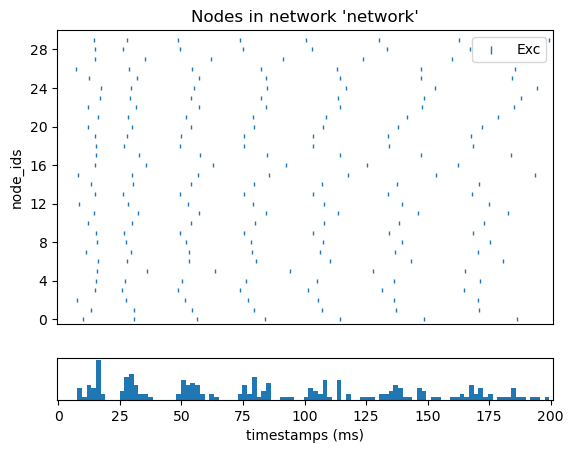

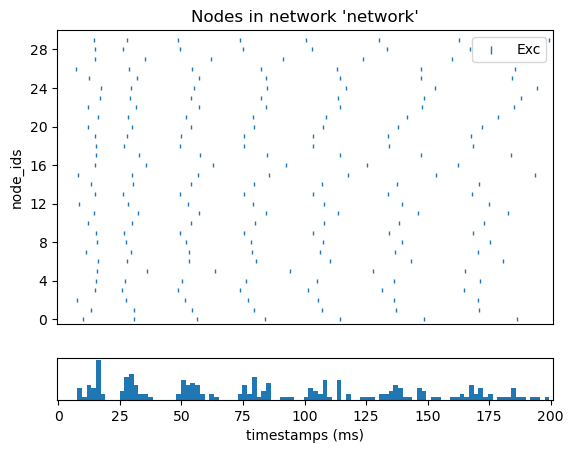

In [15]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='config.json', group_by='pop_name')

# If the plot does not show, run the cell again.

The two plots are the same and show random asynchronous initialization with different external drives. 

This particular network tends toward becoming more asynchronous while the plot in Borgers' book tends toward synchony.